# Applying Feature Selection Techniques



### 1. Importing Libraries and Reading Data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.feature_selection import RFECV,RFE

from sklearn.model_selection import GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, auc, precision_score, recall_score

import os
os.chdir('E:/PGP-DSE/Capstone Project/Group 2/OnlineNewsPopularity')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings



### 2. Reading the dataset


In [15]:

df = pd.read_csv('ONPClass.csv')

df = df.drop(['url','timedelta'],axis=1)


### 3. Custom Functions:

In [16]:
# function for train test split
def perform_train_test_split(x,y,size):
    return train_test_split(x, y, test_size = size, random_state = 0)


# function for scaling the data for train test split
def std_data(xtrain,xtest):
    sc = StandardScaler()
    scaled = sc.fit(xtrain)
    scaled_train = sc.transform(xtrain)
    scaled_test = sc.transform(xtest)
    return scaled_train, scaled_test

# function to scale whole data
def std_data_n(x):
    sc = StandardScaler()
    scaled = sc.fit_transform(x)
    return scaled


# function to apply rfecv onto the dataset
def apply_rfecv(x,y):

    model = RandomForestClassifier(random_state=0)
    rfecv = RFECV(estimator= model, step = 1, cv=5, scoring='roc_auc')
    rfecv.fit(x, y)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    print('Best Features: ', x.columns[rfecv.support_])
    
    rfe_features = pd.DataFrame({'features': X.columns, 'rank':rfecv.ranking_}).sort_values(by = 'rank')
    sel_features = rfe_features[rfe_features['rank']==1]['features'].to_list()
    
    print('Scores: ', rfecv.grid_scores_)
   #sel_features = x.columns[rfecv.support_]
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("CV Score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return sel_features
    
# function for applying random search cv
def random_search_cv(x,y,model,params):
    RS = RandomizedSearchCV(model, params, cv = 5, scoring = 'roc_auc', random_state = 0)
    RS.fit(x,y)
    return RS.best_params_, RS.best_estimator_, RS.best_score_

# function for applying grid search cv
def grid_search_cv(x,y,model,params):
    GS = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc')
    GS.fit(x,y)
    return GS.best_params_, GS.best_estimator_, GS.best_score_


# creating an empty dataframe with headers
# this would store the values for evaluation metric
headers=['AUC Train','AUC Test','Acc Train','Acc Test','Pre Train','Pre Test','Re Train','Re Test']
dfObj = pd.DataFrame(columns = headers)


# function to get roc_auc_scores for train and test  
def fit_predict_plot(xtrain,xtest,ytrain,ytest,models):
    
    for name, model in models:
        
        model.fit(xtrain,ytrain)
        
        y_pred_train = model.predict(xtrain)
        y_pred_test = model.predict(xtest)
        
        probas_train = model.predict_proba(xtrain)[:,1]
        probas_test = model.predict_proba(xtest)[:,1]

        model_name = name 
        
        plot_roc_auc_curve(probas_train,probas_test,ytrain,ytest,name)
        
        return get_metrics(ytrain,ytest,y_pred_train,y_pred_test,probas_train,probas_test,model_name)
    
    
# function to plot the roc auc curve
def plot_roc_auc_curve(probas_train,probas_test,y_train,y_test,name):
    
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train,probas_train)

        fpr_test, tpr_test, thresholds_test = roc_curve(y_test,probas_test)

        
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        plt.plot(fpr_train, tpr_train, color='b', 
                 label=r'Train ROC (AUC = %0.2f )' % (roc_auc_score(y_train,probas_train)),lw=2, alpha=.5)
        plt.plot(fpr_test, tpr_test, color='g', 
                 label=r'Test ROC (AUC = %0.2f )' % (roc_auc_score(y_test,probas_test)),lw=2, alpha=.8)

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title('ROC of %s' % (name),fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()

        

    
# function to get all other metrics
def get_metrics(y_train,y_test,y_pred_train,y_pred_test,probas_train,probas_test,name):
        global dfObj
        print('For Train Data:\n')
        print(confusion_matrix(y_train,y_pred_train))
        #print(classification_report(y_train,y_pred_train))
        
        print('\n For Test Data:\n')
        print(confusion_matrix(y_test,y_pred_test))
        #print(classification_report(y_test,y_pred_test))

        dfObj.loc[name] = [roc_auc_score(y_train,probas_train), roc_auc_score(y_test,probas_test),
                           accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test),
                           precision_score(y_train, y_pred_train), precision_score(y_test, y_pred_test),
                           recall_score(y_train, y_pred_train), recall_score(y_test, y_pred_test)]
        return dfObj
        

# function for applying various models
def implement_cv(x,y,models):
    final = {}
    results = []
    names = []
    auc = []
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_val_score(model,x,y,cv=kfold, scoring='roc_auc')
        results.append((np.abs(cv_results)))
        auc.append(np.mean(results))
        names.append(name)
        print(cv_results)
        final.update({'Model': names , 'roc_auc_score': auc})
    return pd.DataFrame(final)


# dataframe styles
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

def compare_models():
    final_scores = dfObj

    final_scores.columns = ['Train','Test','Train','Test','Train','Test','Train','Test']

    headers = pd.MultiIndex.from_product([['ROC_AUC','ACCURACY','PRECISION','RECALL'],['Train','Test']])

    final_scores.columns = headers

    return final_scores.style.set_table_styles(styles)

In [4]:
X = df.drop(['class','avg_negative_polarity','min_negative_polarity','max_negative_polarity','abs_title_subjectivity',
'weekday_is_friday'],axis = 1 )

Y = df['class']

## 4. Methods of Feature Selection
### 4.1 Backward Elimination

In [10]:
import statsmodels.api as sm

X = df.drop(['class'], axis = 1)
y = df['class']

X_scaled = std_data_n(X)

X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.757447,-0.695210,0.032772,0.000675,0.038658,-0.607463,-0.335566,-0.426526,-0.304268,0.156474,...,0.237337,0.063865,-0.228941,-0.708369,-0.268895,-0.969886,0.671245,-0.975432,-1.810719,0.138920
1,-0.661657,-0.618794,0.016056,0.000675,0.031479,-0.695709,-0.594963,-0.426526,-0.304268,0.432838,...,-0.640040,-0.870968,-0.228941,1.102174,1.367424,0.078642,-0.870807,-0.269076,0.837749,-0.689658
2,-0.661657,-0.712192,0.007645,0.000675,-0.007752,-0.695709,-0.594963,-0.426526,-0.304268,-0.183415,...,1.358401,0.063865,0.981798,-1.621797,-0.957871,-0.270867,-0.870807,-0.269076,0.837749,-0.689658
3,-0.661657,-0.032933,-0.012619,0.000675,-0.007211,-0.166229,-0.854360,-0.426526,-0.304268,-0.169758,...,0.307442,0.573773,0.174639,-0.862584,-0.268895,-0.620377,-0.870807,-0.269076,0.837749,-0.689658
4,1.230482,1.115439,-0.037655,0.000675,-0.045420,0.716237,4.074185,1.860061,-0.304268,0.159400,...,0.548135,-0.870968,0.981798,0.307944,0.075594,0.602906,0.531059,0.244637,-1.569949,-0.087056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,0.284413,-0.425630,-0.005443,0.000675,-0.001346,-0.166229,0.961420,-0.426526,-0.060829,-0.029747,...,-0.191635,0.063865,-0.027151,-0.003726,0.075594,-0.183490,-0.562396,-0.269076,0.308055,-0.689658
39640,0.757447,-0.463838,0.042060,0.000675,0.059999,-0.166229,0.961420,-0.185832,11.380809,-0.169058,...,0.200881,0.573773,-0.228941,0.379044,0.420082,0.078642,0.054425,3.498156,-0.751332,3.729424
39641,-0.188622,-0.221852,-0.009050,0.000675,-0.013798,1.157470,-0.594963,0.897288,-0.060829,0.626110,...,-0.445302,0.573773,-1.036100,-0.758786,-0.957871,-0.620377,0.531059,0.244637,-1.569949,-0.087056
39642,-2.080761,0.287592,-0.002477,0.000675,0.001068,-0.077983,-0.594963,-0.426526,-0.304268,0.505491,...,-1.118934,-0.461978,-1.036100,0.424968,0.075594,0.996104,-0.870807,-0.269076,0.837749,-0.689658


In [12]:
cols = list(X_scaled.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(len(selected_features_BE))

42


In [9]:
X = X_scaled[['n_tokens_content', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'average_token_length', 
              'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 
              'data_channel_is_socmed', 'data_channel_is_tech', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 
              'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_avg_shares', 
              'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 
              'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
              'global_subjectivity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 
              'min_positive_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity']]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_scaled,Y,0.3) # splitting the dataset



In [9]:
len(['n_tokens_content', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'average_token_length', 
              'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 
              'data_channel_is_socmed', 'data_channel_is_tech', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 
              'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_avg_shares', 
              'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 
              'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
              'global_subjectivity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 
              'min_positive_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity'])

42

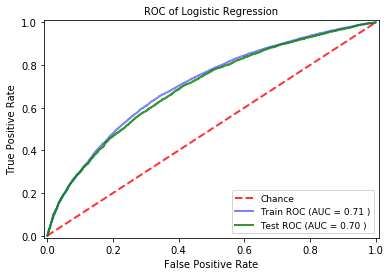

For Train Data:

[[9469 4541]
 [5011 8729]]

 For Test Data:

[[4033 2039]
 [2203 3619]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.706895,0.697693,0.655784,0.64335,0.6578,0.639625,0.635298,0.621608


In [10]:
LOGREG = LogisticRegression(random_state = 0)

models = [('Logistic Regression',LOGREG)]

fit_predict_plot(X_train, X_test, y_train, y_test, models) # implementing the model

### 4.2 Multicollinearity Removal

In [11]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = X_scaled
y = df['class']

print(X.shape)

Xs = sm.add_constant(X)
y = df['class']

logitstatsvif = sm.Logit(y, Xs)
result = logitstatsvif.fit()
result.summary()

(39644, 58)
         Current function value: 0.632890
         Iterations: 35


C:\Users\Ankita\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Ankita\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\Ankita\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Ankita\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Ankita\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  class   No. Observations:                39644
Model:                          Logit   Df Residuals:                    39587
Method:                           MLE   Df Model:                           56
Date:                Sun, 24 May 2020   Pseudo R-squ.:                 0.08682
Time:                        22:47:00   Log-Likelihood:                -25090.
converged:                      False   LL-Null:                       -27476.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0086        nan        nan        nan         nan         nan
n_tokens_title                    0.0046      0.011      0.407      0.684      -0.017       0.027
n_tokens_content                  0.0674      0.020      3.307      0.001       0.027       0.107
n_unique_tokens                   0.5437      1.264      0.430      0.667      -1.933       3.021
n_non_stop_words                346.3728        nan        nan        nan         nan         nan
n_non_stop_unique_tokens         -2.5670      0.993     -2.586      0.010      -4.512      -0.621
num_hrefs                         0.0910      0.015      6.134      0.000       0.062       0.120
num_self_hrefs                   -0.0859      0.013     -6.544      0.000      -0.112      -0.060
num_imgs                          0.0136      0.014      0.974      0.330      -0.014       0.041
num_videos                        0.0059      0.012      0.484      0.629      -0.018       0.030
average_token_length             -0.1289      0.038     -3.383      0.001      -0.204      -0.054
num_keywords                      0.0738      0.013      5.569      0.000       0.048       0.100
data_channel_is_lifestyle        -0.0373      0.017     -2.253      0.024      -0.070      -0.005
data_channel_is_entertainment    -0.1242      0.018     -6.903      0.000      -0.159      -0.089
data_channel_is_bus              -0.1001      0.026     -3.834      0.000      -0.151      -0.049
data_channel_is_socmed            0.1745      0.017     10.428      0.000       0.142       0.207
data_channel_is_tech              0.1735      0.027      6.470      0.000       0.121       0.226
data_channel_is_world            -0.0064      0.029     -0.225      0.822      -0.062       0.050
kw_min_min                        0.1184      0.021      5.568      0.000       0.077       0.160
kw_max_min                        0.1055      0.044      2.375      0.018       0.018       0.193
kw_avg_min                       -0.1220      0.046     -2.679      0.007      -0.211      -0.033
kw_min_max                       -0.0308      0.012     -2.482      0.013      -0.055      -0.006
kw_max_max                       -0.0773      0.023     -3.324      0.001      -0.123      -0.032
kw_avg_max                       -0.0856      0.021     -4.085      0.000      -0.127      -0.045
kw_min_avg                       -0.0998      0.016     -6.077      0.000      -0.132      -0.068
kw_max_avg                       -0.5358      0.031    -17.464      0.000      -0.596      -0.476
kw_avg_avg                        0.9371      0.038     24.664      0.000       0.863       1.012
self_reference_min_shares         0.0675      0.035      1.907      0.057      -0.002       0.137
self_reference_max_shares         0.0304      0.035      0.867      0.386      -0.038       0.099
self_reference_avg_shares         0.0385      0.053      0.727      0.467      -0.065       0.142
weekday

In [12]:
## Applying VIF to all the Variables
### calculating the vif values as multicollinearity exists

#[variance_inflation_factor(X.values, j) for j in range(1, X.shape[1])]

# removing collinear variables
# function definition

def calculate_vif(x):
    thresh = 5.0
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, j) for j in range(x.shape[1])]
    for i in range(1,k):
        print("Iteration no.")
        print(i)
        print(vif)
        a = np.argmax(vif)
        print("Max VIF is for variable no.:")
        print(a)
        if vif[a] <= thresh :
            break
        if i == 1 :          
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1 :
            output = output.drop(output.columns[a],axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)

## passing X to the function so that the multicollinearity gets removed.
train_out = calculate_vif(X)

## Includes only relevant features
train_out

C:\Users\Ankita\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Iteration no.
1
[1.1012704710092607, 3.3234906333922893, 13676.735496465431, 286607.233963066, 8483.534141345799, 1.7311474445846184, 1.4143547225763768, 1.6549233733563025, 1.2548496020753421, 12.605778101601922, 1.506760719482656, 2.3410862059171196, 2.856507400155171, 5.8368514900675335, 2.2929520933261873, 6.243049343272813, 7.107292178206799, 3.8304956905266287, 11.209583516326626, 10.945073779370396, 1.3881541476403703, 4.617895946225518, 3.762824298010178, 2.220571413882661, 7.135302676175982, 10.775188793457632, 6.613215046758816, 8.413080061416432, 19.15024573254578, inf, inf, inf, inf, inf, inf, inf, inf, 778894649.0888718, 543674287.3790736, 896594247.0463156, 981419285.3330358, 941882744.491801, 2.952598583871826, 7.831904720642145, 4.674845469416542, 6.573259506335703, 361.85640826380256, 247.77309987650617, 6.11861598911393, 1.9959624143428454, 3.4197935206297694, 7.7463636102542335, 5.319895773717815, 2.9865348224829646, 2.36903752876236, 1.3248248229947155, 1.4160891975

Iteration no.
9
[1.0925613895210708, 2.193949307923063, 1.0038997374086989, 1.6424436838353036, 1.371300124653361, 1.4306954139287327, 1.238150554188915, 2.945425133833004, 1.4895415241971453, 2.3161417219388967, 2.822141518125455, 5.7772253397802205, 2.275346843554062, 6.179045293834802, 7.039314497123255, 3.8140499009594264, 1.5662430145511335, 1.3872614308367268, 4.605066220480801, 3.622653611523344, 2.1512289103297926, 6.24384704872112, 9.881319954715597, 1.3276056616646028, 1.404023958188714, 1.7212879747254823, 1.723542233515209, 1.7125540859805548, 1.5955759967856347, 1.9789501206662208, 2.5470150593992456, 5.255839739452349, 1.9542541274671927, 5.842220263822592, 5.753303102774655, 2.766861185841729, 7.81380719830438, 4.35082802789166, 6.400906581491038, 8.652743761690031, 6.076457144776892, 1.9276286888692575, 3.2935788057458733, 7.741431000591645, 5.248040257399609, 2.9400673660288867, 2.366574459469924, 1.324020499129693, 1.415482702902921, 2.402960341681598]
Max VIF is for 

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,global_rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.757447,-0.695210,0.038658,-0.607463,-0.335566,-0.426526,-0.304268,0.156474,-1.164821,-0.236445,...,-0.269079,0.237337,0.063865,-0.228941,-0.268895,-0.969886,0.671245,-0.975432,-1.810719,0.138920
1,-0.661657,-0.618794,0.031479,-0.695709,-0.594963,-0.426526,-0.304268,0.432838,-1.688626,-0.236445,...,-0.085507,-0.640040,-0.870968,-0.228941,1.367424,0.078642,-0.870807,-0.269076,0.837749,-0.689658
2,-0.661657,-0.712192,-0.007752,-0.695709,-0.594963,-0.426526,-0.304268,-0.183415,-0.641015,-0.236445,...,-0.658817,1.358401,0.063865,0.981798,-0.957871,-0.270867,-0.870807,-0.269076,0.837749,-0.689658
3,-0.661657,-0.032933,-0.007211,-0.166229,-0.854360,-0.426526,-0.304268,-0.169758,-0.117210,-0.236445,...,0.378984,0.307442,0.573773,0.174639,-0.268895,-0.620377,-0.870807,-0.269076,0.837749,-0.689658
4,1.230482,1.115439,-0.045420,0.716237,4.074185,1.860061,-0.304268,0.159400,-0.117210,-0.236445,...,-0.414241,0.548135,-0.870968,0.981798,0.075594,0.602906,0.531059,0.244637,-1.569949,-0.087056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,0.284413,-0.425630,-0.001346,-0.166229,0.961420,-0.426526,-0.060829,-0.029747,0.406595,-0.236445,...,-0.199605,-0.191635,0.063865,-0.027151,0.075594,-0.183490,-0.562396,-0.269076,0.308055,-0.689658
39640,0.757447,-0.463838,0.059999,-0.166229,0.961420,-0.185832,11.380809,-0.169058,-0.117210,-0.236445,...,-0.689510,0.200881,0.573773,-0.228941,0.420082,0.078642,0.054425,3.498156,-0.751332,3.729424
39641,-0.188622,-0.221852,-0.013798,1.157470,-0.594963,0.897288,-0.060829,0.626110,0.406595,-0.236445,...,0.764224,-0.445302,0.573773,-1.036100,-0.957871,-0.620377,0.531059,0.244637,-1.569949,-0.087056
39642,-2.080761,0.287592,0.001068,-0.077983,-0.594963,-0.426526,-0.304268,0.505491,-1.164821,-0.236445,...,0.632481,-1.118934,-0.461978,-1.036100,0.075594,0.996104,-0.870807,-0.269076,0.837749,-0.689658


In [14]:
X = train_out
y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

X.shape


(39644, 45)

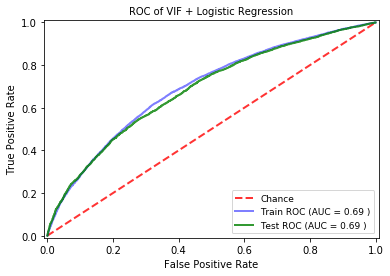

For Train Data:

[[9310 4700]
 [5130 8610]]

 For Test Data:

[[3963 2109]
 [2275 3547]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.706895,0.697693,0.655784,0.643350,0.657800,0.639625,0.635298,0.621608
VIF + Logistic Regression,0.693270,0.685072,0.645766,0.631411,0.646882,0.627122,0.626638,0.609241


In [15]:
VIF_LOGREG = LogisticRegression(solver = 'liblinear',random_state = 0)

models = [('VIF + Logistic Regression',VIF_LOGREG)]

fit_predict_plot(X_train, X_test, y_train, y_test, models) # implementing the model

## Removing Highly Correlated Features


In [47]:
X = df.drop(['class','avg_negative_polarity','min_negative_polarity','max_negative_polarity','abs_title_subjectivity',
'weekday_is_friday'],axis = 1 )

Y = df['class']

### Get the highly correlated features

corr_val = X.corr()

correlated_features = set()
correlation_matrix = corr_val

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)

{'kw_max_max', 'LDA_02', 'self_reference_avg_shares', 'n_non_stop_words', 'kw_avg_min', 'kw_avg_avg', 'n_non_stop_unique_tokens'}


In [52]:
X = df.drop(['class','avg_negative_polarity','min_negative_polarity','max_negative_polarity',
             'abs_title_subjectivity','weekday_is_friday','kw_avg_avg', 'kw_max_max', 'LDA_02', 
             'self_reference_avg_shares', 'n_non_stop_words','kw_avg_min', 'kw_avg_avg', 
             'n_non_stop_unique_tokens'],axis = 1 )

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape

(39644, 46)

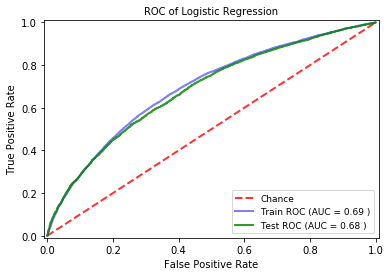

For Train Data:

[[9229 4781]
 [5117 8623]]

 For Test Data:

[[3932 2140]
 [2253 3569]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.693429,0.684852,0.643315,0.630654,0.643315,0.625153,0.627584,0.61302


In [53]:
LOGREG = LogisticRegression(random_state = 0, max_iter = 1000) 

models = [('Logistic Regression', LOGREG)]

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

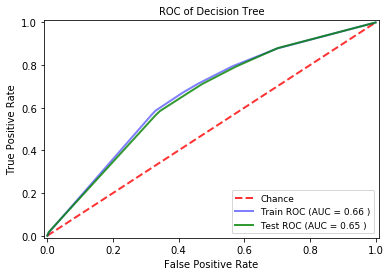

For Train Data:

[[9387 4623]
 [5676 8064]]

 For Test Data:

[[3989 2083]
 [2418 3404]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.693429,0.684852,0.643315,0.630654,0.643315,0.625153,0.627584,0.613020
Decision Tree,0.656881,0.649862,0.628865,0.621574,0.635611,0.620375,0.586900,0.584679


In [54]:
DT = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 10, min_samples_split = 11, random_state = 0)

models = []
models.append(('Decision Tree',DT))

fit_predict_plot(train,test,y_train,y_test,models)



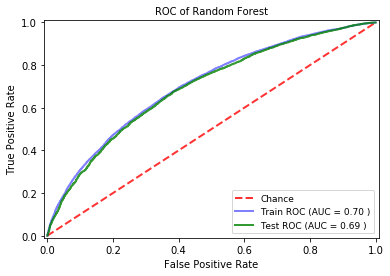

For Train Data:

[[9408 4602]
 [5204 8536]]

 For Test Data:

[[4053 2019]
 [2229 3593]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.693429,0.684852,0.643315,0.630654,0.643315,0.625153,0.627584,0.613020
Decision Tree,0.656881,0.649862,0.628865,0.621574,0.635611,0.620375,0.586900,0.584679
Random Forest,0.703333,0.694280,0.646631,0.642845,0.649718,0.640235,0.621252,0.617142


In [55]:
RF = RandomForestClassifier(max_depth = 3, min_samples_leaf = 10, min_samples_split = 11, random_state = 0)

models = []
models.append(('Random Forest',RF))

fit_predict_plot(train,test,y_train,y_test,models)



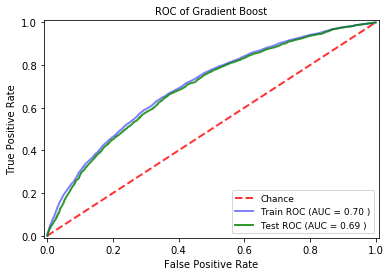

For Train Data:

[[9061 4949]
 [4800 8940]]

 For Test Data:

[[3889 2183]
 [2047 3775]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.693429,0.684852,0.643315,0.630654,0.643315,0.625153,0.627584,0.613020
Decision Tree,0.656881,0.649862,0.628865,0.621574,0.635611,0.620375,0.586900,0.584679
Random Forest,0.703333,0.694280,0.646631,0.642845,0.649718,0.640235,0.621252,0.617142
Gradient Boost,0.702759,0.692646,0.648685,0.644359,0.643675,0.633602,0.650655,0.648403


In [56]:
GB = GradientBoostingClassifier(n_estimators = 20, learning_rate = 0.1, max_depth = 2, min_samples_leaf = 10, 
                                min_samples_split = 11, random_state = 0)

models = []
models.append(('Gradient Boost',GB))

fit_predict_plot(train,test,y_train,y_test,models)



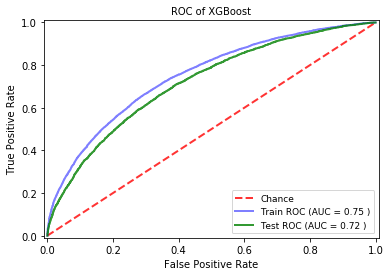

For Train Data:

[[9736 4274]
 [4523 9217]]

 For Test Data:

[[4069 2003]
 [2070 3752]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.693429,0.684852,0.643315,0.630654,0.643315,0.625153,0.627584,0.613020
Decision Tree,0.656881,0.649862,0.628865,0.621574,0.635611,0.620375,0.586900,0.584679
Random Forest,0.703333,0.694280,0.646631,0.642845,0.649718,0.640235,0.621252,0.617142
Gradient Boost,0.702759,0.692646,0.648685,0.644359,0.643675,0.633602,0.650655,0.648403
XGBoost,0.749569,0.718249,0.682991,0.657558,0.683196,0.651955,0.670815,0.644452


In [57]:
XGB = XGBClassifier(learning_rate = 0.1, max_depth = 3, min_child_weight = 1,  random_state = 0)

models = []
models.append(('XGBoost',XGB))

fit_predict_plot(train,test,y_train,y_test,models)



In [58]:
compare_models()

### 4.3 Recursive Feature Elimination (RFECV)

#### Using all features

In [4]:
X = df.drop(['class'],axis = 1 )

Y = df['class']

X_scaled = std_data_n(X)

X_new = pd.DataFrame(X_scaled, columns = X.columns)

X_new.shape

(39644, 58)

Optimal number of features : 40
Best Features:  Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs',
       'average_token_length', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
       'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_shares', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02',
       'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity'],
      dtype='object')
Scores:  [0.53

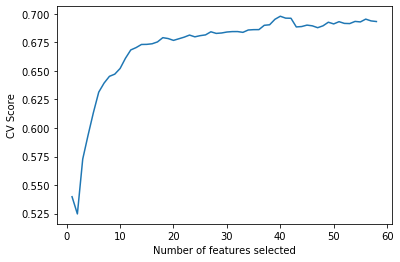

In [5]:
sel_features = apply_rfecv(X_new,Y) # implement RFECV

## Using Significant Features

In [59]:
X = df.drop(['class','avg_negative_polarity','min_negative_polarity','max_negative_polarity',
             'abs_title_subjectivity','weekday_is_friday','kw_max_max', 'LDA_02', 'self_reference_avg_shares', 
             'n_non_stop_words','kw_avg_min', 'kw_avg_avg', 'n_non_stop_unique_tokens'],axis = 1 )

Y = df['class']

X_scaled = std_data_n(X)

X_new = pd.DataFrame(X_scaled, columns = X.columns)

X_new.shape

(39644, 46)

Optimal number of features : 42
Best Features:  Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_entertainment',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max',
       'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_saturday',
       'is_weekend', 'LDA_00', 'LDA_01', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_sentiment_

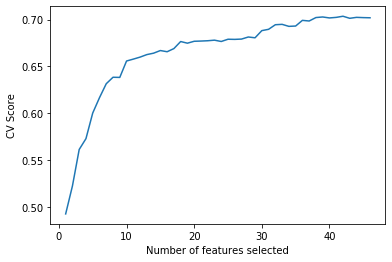

In [60]:
sel_features = apply_rfecv(X_new,Y) # implement RFECV

### Using 42 features for model building

In [17]:
top42 = ['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_entertainment',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max',
       'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_saturday',
       'is_weekend', 'LDA_00', 'LDA_01', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_sentiment_polarity']

print(top42)

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_saturday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_sentiment_polarity']


In [18]:
X = df[top42]
Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)

In [19]:
# run only if required 
dfObj.drop(dfObj.index, inplace=True)

### Logistic Regression

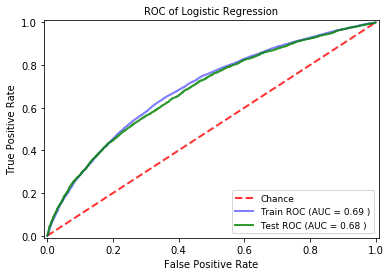

For Train Data:

[[9193 4817]
 [5046 8694]]

 For Test Data:

[[3906 2166]
 [2240 3582]]


ROC_AUC            ACCURACY           PRECISION  \
                        Train      Test     Train      Test     Train   
Logistic Regression  0.691937  0.684304  0.644577  0.629561  0.643476   

                                 RECALL            
                         Test     Train      Test  
Logistic Regression  0.623173  0.632751  0.615252

In [24]:
LOGREG = LogisticRegression(random_state = 0, max_iter = 1000) 

models = [('Logistic Regression', LOGREG)]

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

### Decision Tree

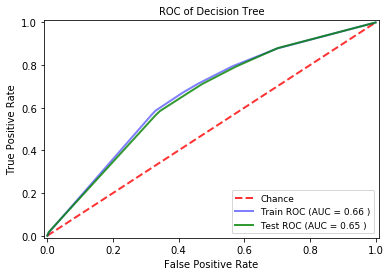

For Train Data:

[[9387 4623]
 [5676 8064]]

 For Test Data:

[[3989 2083]
 [2418 3404]]


ROC_AUC            ACCURACY           PRECISION  \
                        Train      Test     Train      Test     Train   
Logistic Regression  0.691937  0.684304  0.644577  0.629561  0.643476   
Decision Tree        0.656881  0.649862  0.628865  0.621574  0.635611   

                                 RECALL            
                         Test     Train      Test  
Logistic Regression  0.623173  0.632751  0.615252  
Decision Tree        0.620375  0.586900  0.584679

In [25]:
DT = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 10, min_samples_split = 11, random_state = 0)

models = []
models.append(('Decision Tree',DT))

fit_predict_plot(train,test,y_train,y_test,models)

### Random Forest

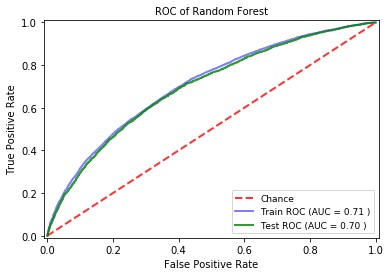

For Train Data:

[[9531 4479]
 [5276 8464]]

 For Test Data:

[[4097 1975]
 [2240 3582]]


ROC_AUC            ACCURACY           PRECISION  \
                        Train      Test     Train      Test     Train   
Logistic Regression  0.691937  0.684304  0.644577  0.629561  0.643476   
Decision Tree        0.656881  0.649862  0.628865  0.621574  0.635611   
Random Forest        0.706835  0.697015  0.648468  0.645620  0.653944   

                                 RECALL            
                         Test     Train      Test  
Logistic Regression  0.623173  0.632751  0.615252  
Decision Tree        0.620375  0.586900  0.584679  
Random Forest        0.644592  0.616012  0.615252

In [26]:

RF = RandomForestClassifier(max_depth = 3, min_samples_leaf = 10, min_samples_split = 11, random_state = 0)

models = []
models.append(('Random Forest',RF))

fit_predict_plot(train,test,y_train,y_test,models)

In [27]:
compare_models()

## Boosting the Models

### Decision Tree

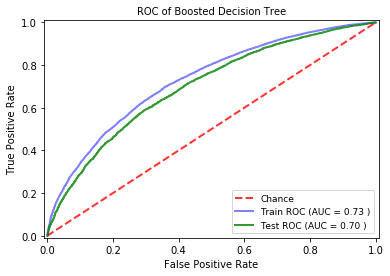

For Train Data:

[[9383 4627]
 [4587 9153]]

 For Test Data:

[[3911 2161]
 [2089 3733]]


ROC_AUC            ACCURACY           PRECISION  \
                          Train      Test     Train      Test     Train   
Logistic Regression    0.691937  0.684304  0.644577  0.629561  0.643476   
Decision Tree          0.656881  0.649862  0.628865  0.621574  0.635611   
Random Forest          0.706835  0.697015  0.648468  0.645620  0.653944   
Boosted Decision Tree  0.729476  0.698854  0.667964  0.642677  0.664224   

                                   RECALL            
                           Test     Train      Test  
Logistic Regression    0.623173  0.632751  0.615252  
Decision Tree          0.620375  0.586900  0.584679  
Random Forest          0.644592  0.616012  0.615252  
Boosted Decision Tree  0.633356  0.666157  0.641189

In [28]:
AB_DT = AdaBoostClassifier(base_estimator = DT, n_estimators = 10, random_state = 0) 

models = []
models.append(('Boosted Decision Tree', AB_DT))

fit_predict_plot(train,test,y_train,y_test,models)

### Random Forest

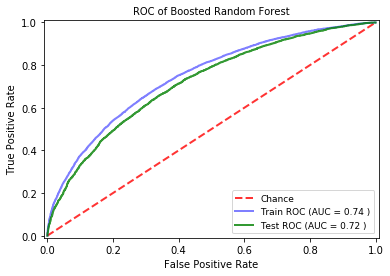

For Train Data:

[[9670 4340]
 [4576 9164]]

 For Test Data:

[[4058 2014]
 [2054 3768]]


ROC_AUC            ACCURACY           PRECISION  \
                          Train      Test     Train      Test     Train   
Logistic Regression    0.691937  0.684304  0.644577  0.629561  0.643476   
Decision Tree          0.656881  0.649862  0.628865  0.621574  0.635611   
Random Forest          0.706835  0.697015  0.648468  0.645620  0.653944   
Boosted Decision Tree  0.729476  0.698854  0.667964  0.642677  0.664224   
Boosted Random Forest  0.744940  0.718482  0.678703  0.657979  0.678614   

                                   RECALL            
                           Test     Train      Test  
Logistic Regression    0.623173  0.632751  0.615252  
Decision Tree          0.620375  0.586900  0.584679  
Random Forest          0.644592  0.616012  0.615252  
Boosted Decision Tree  0.633356  0.666157  0.641189  
Boosted Random Forest  0.651678  0.666958  0.647200

In [29]:
AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 10, random_state = 0) 

models = []
models.append(('Boosted Random Forest', AB_RF))
 
fit_predict_plot(train,test,y_train,y_test,models)

### Gradient Boost

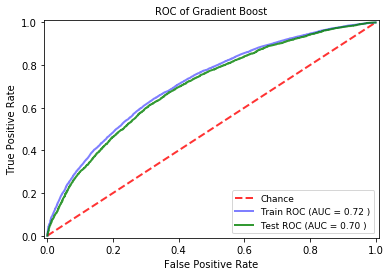

For Train Data:

[[9484 4526]
 [4940 8800]]

 For Test Data:

[[4059 2013]
 [2150 3672]]


ROC_AUC            ACCURACY           PRECISION  \
                          Train      Test     Train      Test     Train   
Logistic Regression    0.691937  0.684304  0.644577  0.629561  0.643476   
Decision Tree          0.656881  0.649862  0.628865  0.621574  0.635611   
Random Forest          0.706835  0.697015  0.648468  0.645620  0.653944   
Boosted Decision Tree  0.729476  0.698854  0.667964  0.642677  0.664224   
Boosted Random Forest  0.744940  0.718482  0.678703  0.657979  0.678614   
Gradient Boost         0.716782  0.702316  0.658883  0.649992  0.660363   

                                   RECALL            
                           Test     Train      Test  
Logistic Regression    0.623173  0.632751  0.615252  
Decision Tree          0.620375  0.586900  0.584679  
Random Forest          0.644592  0.616012  0.615252  
Boosted Decision Tree  0.633356  0.666157  0.641189  
Boosted Random Forest  0.651678  0.666958  0.647200  
Gradient Boost         0.645910  0.640466  0.630711

In [30]:
GB = GradientBoostingClassifier(n_estimators = 20, learning_rate = 0.1, max_depth = 3, min_samples_leaf = 10, 
                                min_samples_split = 11, random_state = 0)

models = []
models.append(('Gradient Boost',GB))

fit_predict_plot(train,test,y_train,y_test,models)



In [31]:
compare_models()

## Note: After this, Boosting Models were tuned

## After tuning the DT and RF models, feature importance is applied

### 4.4 Feature Importance for tuned DT and RF

In [21]:
dfObj.drop(dfObj.index, inplace=True)
dfObj

Empty DataFrame
Columns: [(ROC_AUC, Train), (ROC_AUC, Test), (ACCURACY, Train), (ACCURACY, Test), (PRECISION, Train), (PRECISION, Test), (RECALL, Train), (RECALL, Test)]
Index: []

In [21]:
print(top42)

['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_entertainment', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_saturday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'max_positive_polarity', 'title_subjectivity', 'title_sentiment_polarity', 'abs_title_sentiment_polarity']


In [20]:
X_new = df[top42]
Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_new,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)

X_new.shape

(39644, 42)

In [30]:
imp_features = []

# provide number of imp features to be obtained
n_feat = 20

# function to get importance features
def get_imp_features(model,num,name):
    
    alg = model

    feat_imp = pd.Series(alg.feature_importances_, X.columns).sort_values(ascending=False)
    
    imp_features.append([feat_imp[feat_imp == i].index[0] for i in feat_imp[:num] if i > 0])

    #feat_importances = pd.Series(dt.feature_importances_, index=X.columns)
    
    plt.figure(figsize = (5,5))
    feat_imp.nlargest(num).plot(kind='barh',title='Feature Importances of {}'.format(name))
    plt.xlabel('Feature Importance Score')
    plt.show()


### Find important features for tuned RANDOM FOREST model

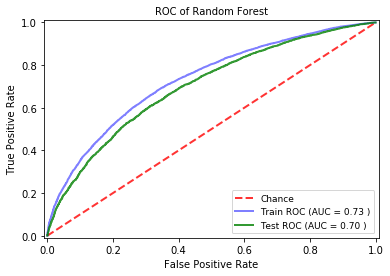

For Train Data:

[[9537 4473]
 [4627 9113]]

 For Test Data:

[[4026 2046]
 [2168 3654]]


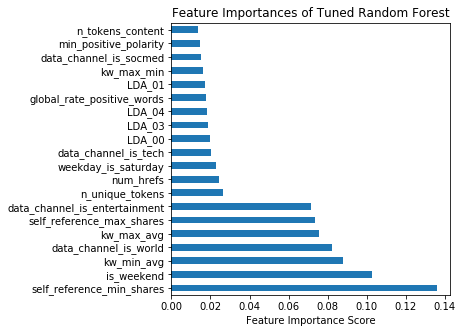

In [31]:
## parameters after tuning
rf_param =  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 9}

RF = RandomForestClassifier(**rf_param, random_state = 0)

models = []
models.append(('Random Forest', RF))

fit_predict_plot(train,test,y_train,y_test,models) # fit model

get_imp_features(RF,n_feat,'Tuned Random Forest') # find imp features

### Find important features for tuned DECISION TREE model

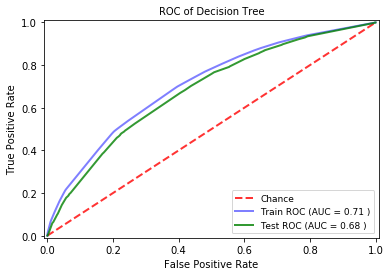

For Train Data:

[[8499 5511]
 [4169 9571]]

 For Test Data:

[[3546 2526]
 [1863 3959]]


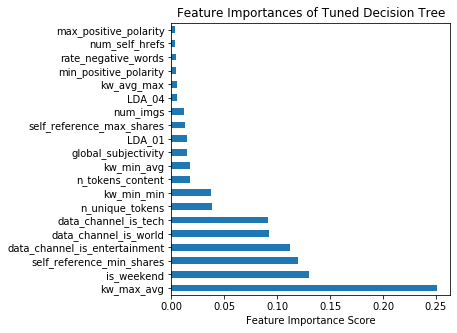

In [33]:

## parameters after tuning
dt_param = {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 9} 

DT = DecisionTreeClassifier(**dt_param, random_state = 0)

models = []
models.append(('Decision Tree',DT))

fit_predict_plot(train,test,y_train,y_test,models) # fit model


get_imp_features(DT,n_feat,'Tuned Decision Tree') # find imp features

## Top 20 Feature for RF and DT

In [79]:
print(imp_features)

[['self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_world', 'kw_max_avg', 'self_reference_max_shares', 'data_channel_is_entertainment', 'n_unique_tokens', 'num_hrefs', 'weekday_is_saturday', 'data_channel_is_tech', 'LDA_00', 'LDA_03', 'LDA_04', 'global_rate_positive_words', 'LDA_01', 'kw_max_min', 'data_channel_is_socmed', 'min_positive_polarity', 'n_tokens_content'], ['kw_max_avg', 'is_weekend', 'self_reference_min_shares', 'data_channel_is_entertainment', 'data_channel_is_world', 'data_channel_is_tech', 'n_unique_tokens', 'kw_min_min', 'n_tokens_content', 'kw_min_avg', 'global_subjectivity', 'LDA_01', 'self_reference_max_shares', 'num_imgs', 'LDA_04', 'kw_avg_max', 'min_positive_polarity', 'rate_negative_words', 'num_self_hrefs', 'max_positive_polarity']]


## Top 25 Feature for RF and DT

In [86]:
print(imp_features)

[['self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_world', 'kw_max_avg', 'self_reference_max_shares', 'data_channel_is_entertainment', 'n_unique_tokens', 'num_hrefs', 'weekday_is_saturday', 'data_channel_is_tech', 'LDA_00', 'LDA_03', 'LDA_04', 'global_rate_positive_words', 'LDA_01', 'kw_max_min', 'data_channel_is_socmed', 'min_positive_polarity', 'n_tokens_content', 'global_subjectivity', 'average_token_length', 'kw_avg_max', 'num_imgs', 'kw_min_min'], ['kw_max_avg', 'is_weekend', 'self_reference_min_shares', 'data_channel_is_entertainment', 'data_channel_is_world', 'data_channel_is_tech', 'n_unique_tokens', 'kw_min_min', 'n_tokens_content', 'kw_min_avg', 'global_subjectivity', 'LDA_01', 'self_reference_max_shares', 'num_imgs', 'LDA_04', 'kw_avg_max', 'min_positive_polarity', 'rate_negative_words', 'num_self_hrefs', 'max_positive_polarity', 'rate_positive_words', 'global_rate_positive_words', 'num_videos', 'average_token_length', 'LDA_03']]


## Top 30 Feature for RF and DT

In [98]:
print(imp_features)

[['self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_world', 'kw_max_avg', 'self_reference_max_shares', 'data_channel_is_entertainment', 'n_unique_tokens', 'num_hrefs', 'weekday_is_saturday', 'data_channel_is_tech', 'LDA_00', 'LDA_03', 'LDA_04', 'global_rate_positive_words', 'LDA_01', 'kw_max_min', 'data_channel_is_socmed', 'min_positive_polarity', 'n_tokens_content', 'global_subjectivity', 'average_token_length', 'kw_avg_max', 'num_imgs', 'kw_min_min', 'global_sentiment_polarity', 'num_keywords', 'avg_positive_polarity', 'num_self_hrefs', 'global_rate_negative_words'], ['kw_max_avg', 'is_weekend', 'self_reference_min_shares', 'data_channel_is_entertainment', 'data_channel_is_world', 'data_channel_is_tech', 'n_unique_tokens', 'kw_min_min', 'n_tokens_content', 'kw_min_avg', 'global_subjectivity', 'LDA_01', 'self_reference_max_shares', 'num_imgs', 'LDA_04', 'kw_avg_max', 'min_positive_polarity', 'rate_negative_words', 'num_self_hrefs', 'max_positive_polarity', 'rat

## Top 40 Feature for RF and DT


In [102]:
print(imp_features)

[['self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_world', 'kw_max_avg', 'self_reference_max_shares', 'data_channel_is_entertainment', 'n_unique_tokens', 'num_hrefs', 'weekday_is_saturday', 'data_channel_is_tech', 'LDA_00', 'LDA_03', 'LDA_04', 'global_rate_positive_words', 'LDA_01', 'kw_max_min', 'data_channel_is_socmed', 'min_positive_polarity', 'n_tokens_content', 'global_subjectivity', 'average_token_length', 'kw_avg_max', 'num_imgs', 'kw_min_min', 'global_sentiment_polarity', 'num_keywords', 'avg_positive_polarity', 'num_self_hrefs', 'global_rate_negative_words', 'kw_min_max', 'title_sentiment_polarity', 'rate_negative_words', 'max_positive_polarity', 'rate_positive_words', 'abs_title_sentiment_polarity', 'n_tokens_title', 'title_subjectivity', 'weekday_is_wednesday', 'num_videos'], ['kw_max_avg', 'is_weekend', 'self_reference_min_shares', 'data_channel_is_entertainment', 'data_channel_is_world', 'data_channel_is_tech', 'n_unique_tokens', 'kw_min_min', 'n_t

## Decision Tree with 20 features

In [129]:
dt_param = {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 9} 

In [130]:
dt20 = ['kw_max_avg', 'is_weekend', 'self_reference_min_shares', 'data_channel_is_entertainment', 'data_channel_is_world', 'data_channel_is_tech', 'n_unique_tokens', 'kw_min_min', 'n_tokens_content', 'kw_min_avg', 'global_subjectivity', 'LDA_01', 'self_reference_max_shares', 'num_imgs', 'LDA_04', 'kw_avg_max', 'min_positive_polarity', 'rate_negative_words', 'num_self_hrefs', 'max_positive_polarity']

In [131]:
X_new = df[dt20]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_new,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)

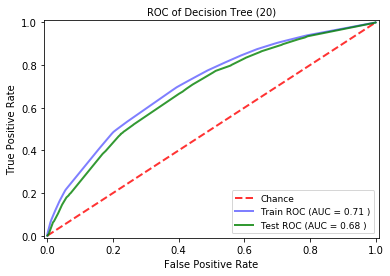

For Train Data:

[[8534 5476]
 [4220 9520]]

 For Test Data:

[[3568 2504]
 [1886 3936]]


ROC_AUC            ACCURACY           PRECISION           \
                      Train      Test     Train      Test     Train     Test   
Decision Tree (20)  0.70747  0.683129  0.650595  0.630906  0.634836  0.61118   

                      RECALL            
                       Train      Test  
Decision Tree (20)  0.692868  0.676056

In [132]:
DT = DecisionTreeClassifier(**dt_param, random_state = 0)

models = []
models.append(('Decision Tree (20)',DT))

fit_predict_plot(train,test,y_train,y_test,models) # fit model

## Decision Tree with 25 features

In [133]:
dt25 = ['kw_max_avg', 'is_weekend', 'self_reference_min_shares', 'data_channel_is_entertainment', 'data_channel_is_world', 'data_channel_is_tech', 'n_unique_tokens', 'kw_min_min', 'n_tokens_content', 'kw_min_avg', 'global_subjectivity', 'LDA_01', 'self_reference_max_shares', 'num_imgs', 'LDA_04', 'kw_avg_max', 'min_positive_polarity', 'rate_negative_words', 'num_self_hrefs', 'max_positive_polarity', 'rate_positive_words', 'global_rate_positive_words', 'num_videos', 'average_token_length', 'LDA_03']

In [134]:
X_new = df[dt25]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_new,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)

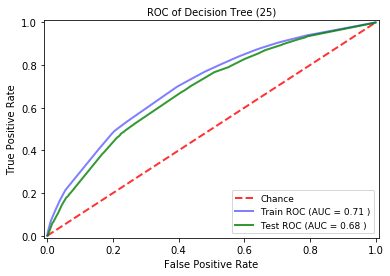

For Train Data:

[[8499 5511]
 [4169 9571]]

 For Test Data:

[[3546 2526]
 [1863 3959]]


ROC_AUC            ACCURACY           PRECISION  \
                       Train      Test     Train      Test     Train   
Decision Tree (20)  0.707470  0.683129  0.650595  0.630906  0.634836   
Decision Tree (25)  0.707696  0.682840  0.651171  0.630990  0.634598   

                                RECALL            
                        Test     Train      Test  
Decision Tree (20)  0.611180  0.692868  0.676056  
Decision Tree (25)  0.610486  0.696579  0.680007

In [135]:
DT = DecisionTreeClassifier(**dt_param, random_state = 0)

models = []
models.append(('Decision Tree (25)',DT))

fit_predict_plot(train,test,y_train,y_test,models) # fit model

## Decision Tree with 30 features

- does not utilize all 30 features
- it has only 26 features

In [136]:

dt30 = ['kw_max_avg', 'is_weekend', 'self_reference_min_shares', 'data_channel_is_entertainment', 'data_channel_is_world', 'data_channel_is_tech', 'n_unique_tokens', 'kw_min_min', 'n_tokens_content', 'kw_min_avg', 'global_subjectivity', 'LDA_01', 'self_reference_max_shares', 'num_imgs', 'LDA_04', 'kw_avg_max', 'min_positive_polarity', 'rate_negative_words', 'num_self_hrefs', 'max_positive_polarity', 'rate_positive_words', 'global_rate_positive_words', 'num_videos', 'average_token_length', 'LDA_03', 'avg_positive_polarity']

In [137]:
X_new = df[dt30]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_new,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)

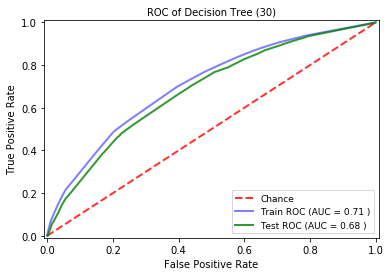

For Train Data:

[[8499 5511]
 [4169 9571]]

 For Test Data:

[[3546 2526]
 [1863 3959]]


ROC_AUC            ACCURACY           PRECISION  \
                       Train      Test     Train      Test     Train   
Decision Tree (20)  0.707470  0.683129  0.650595  0.630906  0.634836   
Decision Tree (25)  0.707696  0.682840  0.651171  0.630990  0.634598   
Decision Tree (30)  0.707696  0.682840  0.651171  0.630990  0.634598   

                                RECALL            
                        Test     Train      Test  
Decision Tree (20)  0.611180  0.692868  0.676056  
Decision Tree (25)  0.610486  0.696579  0.680007  
Decision Tree (30)  0.610486  0.696579  0.680007

In [138]:
DT = DecisionTreeClassifier(**dt_param, random_state = 0)

models = []
models.append(('Decision Tree (30)',DT))

fit_predict_plot(train,test,y_train,y_test,models) # fit model

## Decision Tree with 40 features

In [126]:
 dt40 = ['kw_max_avg', 'is_weekend', 'self_reference_min_shares', 'data_channel_is_entertainment', 'data_channel_is_world', 'data_channel_is_tech', 'n_unique_tokens', 'kw_min_min', 'n_tokens_content', 'kw_min_avg', 'global_subjectivity', 'LDA_01', 'self_reference_max_shares', 'num_imgs', 'LDA_04', 'kw_avg_max', 'min_positive_polarity', 'rate_negative_words', 'num_self_hrefs', 'max_positive_polarity', 'rate_positive_words', 'global_rate_positive_words', 'num_videos', 'average_token_length', 'LDA_03', 'avg_positive_polarity']

In [139]:
len(dt40)

26

In [140]:
compare_models()

## Random Forest with 20 features

In [104]:

rf_param =  {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 9}

In [105]:

rf20 = ['self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_world', 'kw_max_avg', 'self_reference_max_shares', 'data_channel_is_entertainment', 'n_unique_tokens', 'num_hrefs', 'weekday_is_saturday', 'data_channel_is_tech', 'LDA_00', 'LDA_03', 'LDA_04', 'global_rate_positive_words', 'LDA_01', 'kw_max_min', 'data_channel_is_socmed', 'min_positive_polarity', 'n_tokens_content']

In [106]:
X_new = df[rf20]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_new,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)

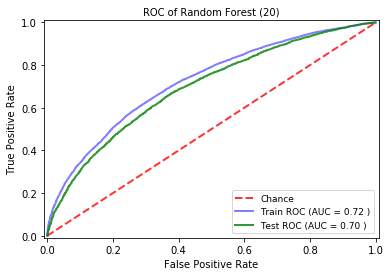

For Train Data:

[[9548 4462]
 [4893 8847]]

 For Test Data:

[[3984 2088]
 [2166 3656]]


ROC_AUC            ACCURACY           PRECISION           \
                       Train      Test     Train      Test     Train     Test   
Random Forest (20)  0.722505  0.695562  0.662883  0.642341  0.664738  0.63649   

                      RECALL            
                       Train      Test  
Random Forest (20)  0.643886  0.627963

In [107]:

RF = RandomForestClassifier(**rf_param, random_state = 0)

models = []
models.append(('Random Forest (20)', RF))

fit_predict_plot(train,test,y_train,y_test,models) # fit model

## Random Forest with 25 features

In [108]:

rf25 = ['self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_world', 'kw_max_avg', 'self_reference_max_shares', 'data_channel_is_entertainment', 'n_unique_tokens', 'num_hrefs', 'weekday_is_saturday', 'data_channel_is_tech', 'LDA_00', 'LDA_03', 'LDA_04', 'global_rate_positive_words', 'LDA_01', 'kw_max_min', 'data_channel_is_socmed', 'min_positive_polarity', 'n_tokens_content', 'global_subjectivity', 'average_token_length', 'kw_avg_max', 'num_imgs', 'kw_min_min']

In [109]:
X_new = df[rf25]

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_new,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)


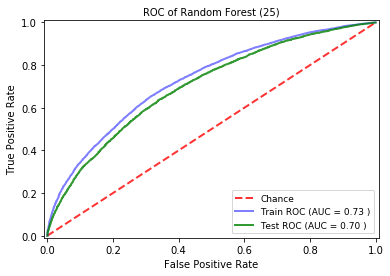

For Train Data:

[[9248 4762]
 [4460 9280]]

 For Test Data:

[[3879 2193]
 [2009 3813]]


ROC_AUC            ACCURACY           PRECISION  \
                       Train      Test     Train      Test     Train   
Random Forest (20)  0.722505  0.695562  0.662883  0.642341  0.664738   
Random Forest (25)  0.727993  0.701408  0.667676  0.646713  0.660875   

                                RECALL            
                        Test     Train      Test  
Random Forest (20)  0.636490  0.643886  0.627963  
Random Forest (25)  0.634865  0.675400  0.654930

In [110]:

RF = RandomForestClassifier(**rf_param, random_state = 0)

models = []
models.append(('Random Forest (25)', RF))

fit_predict_plot(train,test,y_train,y_test,models) # fit model

## Random Forest with 30 features

In [111]:


rf30 = ['self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_world', 'kw_max_avg', 'self_reference_max_shares', 'data_channel_is_entertainment', 'n_unique_tokens', 'num_hrefs', 'weekday_is_saturday', 'data_channel_is_tech', 'LDA_00', 'LDA_03', 'LDA_04', 'global_rate_positive_words', 'LDA_01', 'kw_max_min', 'data_channel_is_socmed', 'min_positive_polarity', 'n_tokens_content', 'global_subjectivity', 'average_token_length', 'kw_avg_max', 'num_imgs', 'kw_min_min', 'global_sentiment_polarity', 'num_keywords', 'avg_positive_polarity', 'num_self_hrefs', 'global_rate_negative_words']

In [112]:
X_new = df[rf30]
Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_new,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)

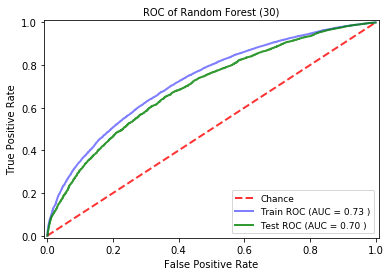

For Train Data:

[[9788 4222]
 [5112 8628]]

 For Test Data:

[[4163 1909]
 [2315 3507]]


ROC_AUC            ACCURACY           PRECISION  \
                       Train      Test     Train      Test     Train   
Random Forest (20)  0.722505  0.695562  0.662883  0.642341  0.664738   
Random Forest (25)  0.727993  0.701408  0.667676  0.646713  0.660875   
Random Forest (30)  0.727061  0.698405  0.663640  0.644863  0.671440   

                                RECALL            
                        Test     Train      Test  
Random Forest (20)  0.636490  0.643886  0.627963  
Random Forest (25)  0.634865  0.675400  0.654930  
Random Forest (30)  0.647526  0.627948  0.602370

In [113]:
RF = RandomForestClassifier(**rf_param, random_state = 0)

models = []
models.append(('Random Forest (30)', RF))

fit_predict_plot(train,test,y_train,y_test,models) # fit model

## Random forest with 40 features

In [114]:

rf40 = ['self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_world', 'kw_max_avg', 'self_reference_max_shares', 'data_channel_is_entertainment', 'n_unique_tokens', 'num_hrefs', 'weekday_is_saturday', 'data_channel_is_tech', 'LDA_00', 'LDA_03', 'LDA_04', 'global_rate_positive_words', 'LDA_01', 'kw_max_min', 'data_channel_is_socmed', 'min_positive_polarity', 'n_tokens_content', 'global_subjectivity', 'average_token_length', 'kw_avg_max', 'num_imgs', 'kw_min_min', 'global_sentiment_polarity', 'num_keywords', 'avg_positive_polarity', 'num_self_hrefs', 'global_rate_negative_words', 'kw_min_max', 'title_sentiment_polarity', 'rate_negative_words', 'max_positive_polarity', 'rate_positive_words', 'abs_title_sentiment_polarity', 'n_tokens_title', 'title_subjectivity', 'weekday_is_wednesday', 'num_videos']

In [115]:
X_new = df[rf40]
Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_new,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)

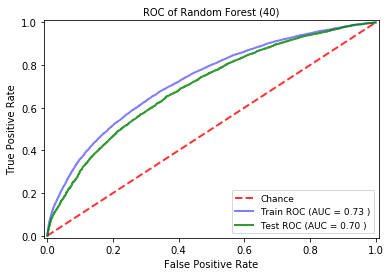

For Train Data:

[[9257 4753]
 [4503 9237]]

 For Test Data:

[[3902 2170]
 [2075 3747]]


ROC_AUC            ACCURACY           PRECISION  \
                       Train      Test     Train      Test     Train   
Random Forest (20)  0.722505  0.695562  0.662883  0.642341  0.664738   
Random Forest (25)  0.727993  0.701408  0.667676  0.646713  0.660875   
Random Forest (30)  0.727061  0.698405  0.663640  0.644863  0.671440   
Random Forest (40)  0.729829  0.699770  0.666450  0.643097  0.660257   

                                RECALL            
                        Test     Train      Test  
Random Forest (20)  0.636490  0.643886  0.627963  
Random Forest (25)  0.634865  0.675400  0.654930  
Random Forest (30)  0.647526  0.627948  0.602370  
Random Forest (40)  0.633260  0.672271  0.643593

In [116]:
RF = RandomForestClassifier(**rf_param, random_state = 0)

models = []
models.append(('Random Forest (40)', RF))

fit_predict_plot(train,test,y_train,y_test,models) # fit model

In [117]:
compare_models()

## Feature Importance for Tuned Gradient Boost

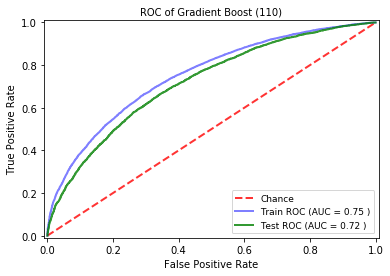

For Train Data:

[[9776 4234]
 [4547 9193]]

 For Test Data:

[[4088 1984]
 [2062 3760]]


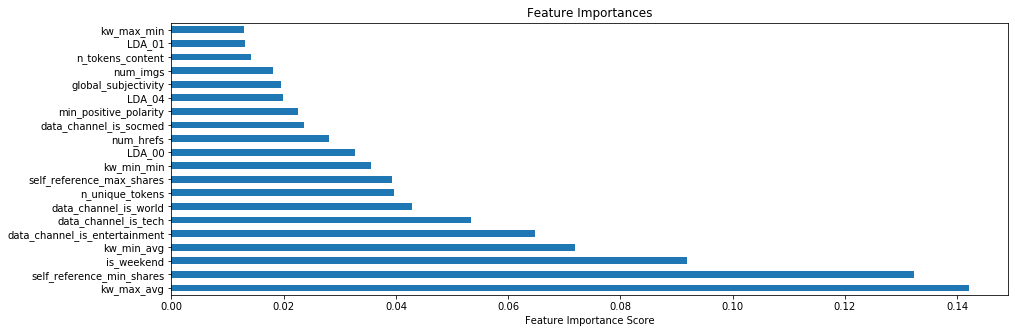

In [31]:
GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)

models = []
models.append(('Gradient Boost (100)',GB))

fit_predict_plot(train,test,y_train,y_test,models)

get_imp_features(GB,n_feat) # find imp features

In [32]:
print(imp_features)

[['kw_max_avg', 'self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_entertainment', 'data_channel_is_tech', 'data_channel_is_world', 'n_unique_tokens', 'self_reference_max_shares', 'kw_min_min', 'LDA_00', 'num_hrefs', 'data_channel_is_socmed', 'min_positive_polarity', 'LDA_04', 'global_subjectivity', 'num_imgs', 'n_tokens_content', 'LDA_01', 'kw_max_min']]


## Top 20 features of GB

In [33]:
gb20 =['kw_max_avg', 'self_reference_min_shares', 'is_weekend', 'kw_min_avg', 'data_channel_is_entertainment', 'data_channel_is_tech', 'data_channel_is_world', 'n_unique_tokens', 'self_reference_max_shares', 'kw_min_min', 'LDA_00', 'num_hrefs', 'data_channel_is_socmed', 'min_positive_polarity', 'LDA_04', 'global_subjectivity', 'num_imgs', 'n_tokens_content', 'LDA_01', 'kw_max_min']

In [34]:
X_new = df[gb20]
Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_new,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test)

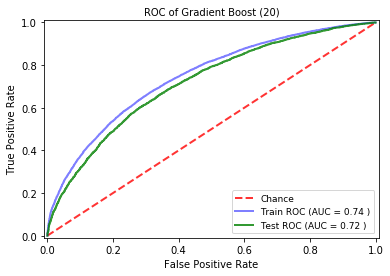

For Train Data:

[[9713 4297]
 [4609 9131]]

 For Test Data:

[[4066 2006]
 [2064 3758]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Random Forest,0.730784,0.699953,0.672072,0.645704,0.670764,0.641053,0.663246,0.627619
Gradient Boost (110),0.750584,0.718745,0.683568,0.659828,0.684665,0.654596,0.669068,0.645826
Gradient Boost (20),0.744065,0.717145,0.679063,0.657811,0.679997,0.651978,0.664556,0.645483


In [35]:
GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)

models = []
models.append(('Gradient Boost',GB))

fit_predict_plot(train,test,y_train,y_test,models)

In [192]:
dfObj.drop(dfObj.index, inplace=True)
dfObj

Empty DataFrame
Columns: [(ROC_AUC, Train), (ROC_AUC, Test), (ACCURACY, Train), (ACCURACY, Test), (PRECISION, Train), (PRECISION, Test), (RECALL, Train), (RECALL, Test)]
Index: []

# ----------------------- END --------------------------